**Neighborhood Growth Model**

In [28]:
import numpy as np
import pandas as pd
import scipy as sp
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_validate
from sklearn.metrics import r2_score
import category_encoders as ce
import xgboost as xgb
import matplotlib.pyplot as mpl


In [29]:

# load all data
raw_data_t1 = pd.read_csv("/Users/dylanvanbramer/indresearch/xu/deep_learning/bci_census/bci_1985.csv")
raw_data_t2 = pd.read_csv("/Users/dylanvanbramer/indresearch/xu/deep_learning/bci_census/bci_1990.csv")

# load the first quadrat that we will be working with
quad1_t1 = raw_data_t1.loc[raw_data_t1['quadrat']==1]
quad1_t2 = raw_data_t2.loc[raw_data_t2['quadrat']==1]




/var/folders/zf/kbwgwbdd4gjfhdxc9cnw8qgm0000gn/T/ipykernel_37675/3378070634.py:2: DtypeWarning: Columns (14,16) have mixed types. Specify dtype option on import or set low_memory=False.
  raw_data_t1 = pd.read_csv("/Users/dylanvanbramer/indresearch/xu/deep_learning/bci_census/bci_1985.csv")
/var/folders/zf/kbwgwbdd4gjfhdxc9cnw8qgm0000gn/T/ipykernel_37675/3378070634.py:3: DtypeWarning: Columns (14,16) have mixed types. Specify dtype option on import or set low_memory=False.
  raw_data_t2 = pd.read_csv("/Users/dylanvanbramer/indresearch/xu/deep_learning/bci_census/bci_1990.csv")


In [30]:
# we only care about the tree IDs and DBHs of quad1_t2
expected_labels = quad1_t2[['treeID', 'dbh']]
expected_labels = expected_labels.rename(columns={"dbh": "dbh2", "treeID": "treeID2"})

#quad1_t1.head()
# simplify the data to have less features
quad1_t1 = quad1_t1[['treeID', 'sp', 'gx', 'gy', 'dbh']]
quad1_t1 = quad1_t1.rename(columns={"dbh": "dbh1", "treeID":"treeID1"})



In [31]:
encoder= ce.BinaryEncoder(cols=['sp'],return_df=True)
quad1_t1 = encoder.fit_transform(quad1_t1)
df_combined = pd.concat([quad1_t1, expected_labels], axis=1)

# Drop rows with any NaN values
df_combined_clean = df_combined.dropna()

# Now has more values because species is encoded to 7 different categories



In [32]:
# Separate the cleaned DataFrame and labels
df_clean = df_combined_clean[quad1_t1.columns]
labels_clean = df_combined_clean[expected_labels.columns]

quad1_t1 = df_clean.to_numpy()
expected_labels = labels_clean.to_numpy()

quad1_t1 = quad1_t1.astype(np.float32)
expected_labels = expected_labels.astype(np.float32)

In [33]:
ids = quad1_t1[:,0]
x_coordinates = quad1_t1[:, 8]  
y_coordinates = quad1_t1[:, 9]
coord_matrix = np.column_stack((x_coordinates, y_coordinates))
spatial_tree = sp.spatial.KDTree(coord_matrix)

In [34]:
nn_dist_matrix2 = np.zeros((len(coord_matrix),6))
nn_ind_matrix2 = np.zeros((len(coord_matrix),6))
nn_feats = np.column_stack((quad1_t1[:, 0:8], quad1_t1[:,10]))
feats_matrix = np.zeros((len(coord_matrix),54))

In [35]:
# NEW CODE AS OF JULY 6 - THIS WORKS!!!!!!!!

for i, tree in enumerate(coord_matrix):
    dist2, ind2 = spatial_tree.query(tree, k=6)
    nn_ind_matrix2[i] = ids[ind2]
    nn_dist_matrix2[i]= dist2

   
    nn_row = nn_feats[i].reshape(1,9)
    inc = 0
    for j in nn_ind_matrix2[i][1:]:
        row_ind = np.where(quad1_t1[:,0] == j)

        real_row = (quad1_t1[row_ind])
        distance = dist2[1:][inc].reshape(1,1)
        dbh = real_row[:,10].reshape(1,1)
        nn_row = np.hstack((nn_row, distance, real_row[:,1:8],dbh))
        inc += 1
    
    feats_matrix[i] = nn_row
    
nn_ind_matrix2 = nn_ind_matrix2[:,1:]
nn_dist_matrix2 = nn_dist_matrix2[:,1:]
# remove the columns with the focal tree's OWN distance and IDS



In [36]:
# change the labels so that they show GROWTH, not future DBH - better for readability of loss
expected_labels[:,1] = expected_labels[:,1] - quad1_t1[:,10]
expected_labels = np.where (expected_labels<0, 0, expected_labels)
X_train, X_test, y_train, y_test = train_test_split(feats_matrix, expected_labels, test_size=0.3)

feats = X_train[:,1:]
labels = y_train[:,1]

test_ids = X_test[:,0]
test_feats = X_test[:,1:]

Using SKLearn's Random Forest Regressor

In [37]:
random_forest = RandomForestRegressor()
random_forest.fit(feats,labels)

preds = random_forest.predict(test_feats)
preds_matrix = np.column_stack((test_ids, preds))

error1 = sklearn.metrics.mean_squared_error(y_test[:,1], preds)
print (np.sqrt(error1))
error1a = r2_score(y_test[:,1],preds)
print (error1a)

16.214483971936648
0.4022142683348636


Using XGBoost Regressor

In [38]:
xgb_tree = xgb.XGBRegressor()
xgb_tree.fit(feats,labels)
preds2 = xgb_tree.predict(test_feats)
predictions_matrix = np.column_stack((test_ids, preds2))
error2 = sklearn.metrics.mean_squared_error(y_test[:,1], preds2)
print (np.sqrt(error2))
error2a = r2_score (y_test[:,1], preds2)
print (error2a)

14.537806
0.5194517573703665


Using K Folds Cross Validation to Introduce Randomness!

In [39]:
cv = KFold(n_splits=5)
cv_rf = RandomForestRegressor()

scores = cross_validate(cv_rf, feats_matrix, expected_labels, scoring=('neg_root_mean_squared_error','r2'), cv=cv)

print (scores['test_neg_root_mean_squared_error'])
print (scores['test_r2'])

[-2.10576512e+04 -2.16069435e+02 -1.40897262e+01 -2.27107768e+02
 -1.82727487e+03]
[  -6.2716063  -696.96866342   -1.43453799 -597.63774625   -2.05716793]


Every matrix Mn has same dimensions of 138 x 5
for m2, we have [2 4 3 1 5]
for 
randomly generate 20 arrangements of 

vertically stack these to get 138 x 20 rows

then also track the 

Goal is to minimize overfitting!
Tell it that order doesn't matter, but instead should use the order of the distance!
If we give it the right distance, it should work correctly

generate 20 arrangements
loop through those
for each, keep the focal tree
then generate new Mn, then stack and train

**Randomization attempts below!**

In [40]:
# generate 20 random sequences of 1 to 5 - COMPLETE
rng = np.random.default_rng()
matrix_order = np.zeros((20,5))

shuffle_this = np.array([0, 1, 2, 3, 4])
for i in range(20):
  current_row = rng.permutation(shuffle_this)
  matrix_order[i] = current_row


In [41]:
nn_dist_matrix3 = np.zeros((len(coord_matrix),6))
nn_ind_matrix3 = np.zeros((len(coord_matrix),6))
nn_feats2 = np.column_stack((quad1_t1[:, 0:8], quad1_t1[:,10]))
#feats_matrix = np.zeros((len(coord_matrix),54))

In [42]:
# Start with feats_matrix above. Then create similar matrices for each of the above
feats_matrix_big = feats_matrix.copy()

zer_indices = range(9,18)
one_indices = range (18,27)
two_indices = range (27,36)
three_indices = range (36,45)
four_indices = range (45,54)

# the long number passing into range is ust n=20 here, but this would make it less hard-coded in
for i in range(np.shape(matrix_order)[0]):
    # loop through each permutation.
    feats_matrix_small = feats_matrix.copy()
    perm_indices = [[0,1,2,3,4,5,6,7,8]]
    current_perm = matrix_order[i]
    for x in current_perm:
        if x == 0:
          perm_indices.append(zer_indices)
        elif x == 1:
           perm_indices.append(one_indices)
        elif x == 2:
           perm_indices.append(two_indices)
        elif x == 3:
           perm_indices.append(three_indices)
        elif x == 4:
           perm_indices.append(four_indices)
    flattened = []
    for sublist in perm_indices:
       for item in sublist:
          flattened.append(item)
    feats_matrix_small = feats_matrix_small[:,flattened]
    feats_matrix_big = np.vstack((feats_matrix_big,feats_matrix_small))

In [43]:
# Create the corresponding y labels - THIS WORKS! # of rows = 138x20
expected_labels2 = expected_labels.copy()
for i in range(20):
    expected_labels2 = np.vstack((expected_labels2, expected_labels))

In [65]:
cv2 = KFold(n_splits=5)
cv_rf2 = RandomForestRegressor()

scores = cross_validate(cv_rf2, feats_matrix_big[:,1:], expected_labels2[:,1], scoring=('neg_root_mean_squared_error','r2'), cv=cv)
print(scores)

{'fit_time': array([1.59589815, 1.61942196, 1.62140417, 1.58728075, 1.58867884]), 'score_time': array([0.01416183, 0.01403189, 0.01437378, 0.01445627, 0.01434016]), 'test_neg_root_mean_squared_error': array([-1.73924351, -2.30398527, -1.19070235, -2.57474357, -1.90042042]), 'test_r2': array([0.99016082, 0.98327606, 0.99541171, 0.98171535, 0.98826609])}


Now, graph the most common species.

In [66]:
rf2 = RandomForestRegressor()
rf2.fit(feats_matrix_big[:,1:], expected_labels2[:,1])

RandomForestRegressor()

In [67]:
all_dbhs = np.arange(10,501).transpose()

copy1 = feats_matrix_big[:,1:]

# create 53 
sp_label = np.atleast_2d(feats_matrix_big[0,1:8])

sp_repeated = np.repeat(sp_label,491,axis=0)

sp_1 = np.column_stack((sp_repeated,all_dbhs))

sp_1 = np.hstack((sp_1, np.zeros((491,45))))

predictions_sp1 = rf2.predict(sp_1)

print ()

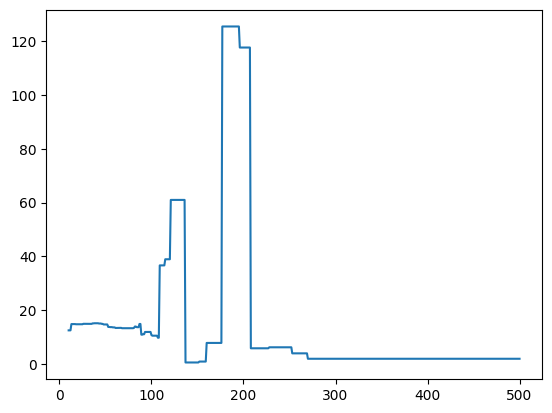

In [68]:
mpl.plot(all_dbhs,predictions_sp1)